In [2]:
import sys
sys.path.append("..")
from toolkit.ascfile import read_asc
from glob import glob
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
from toolkit.dataset import load_spectral_data, dataset_dict_to_dense, normalize_spectra
import torch
def torchify(X, dtype=torch.float):
    return torch.from_numpy(X).type(dtype)

In [222]:
# Training data
from scipy.signal import savgol_filter
dataset_dict = load_spectral_data([
    "../raw_data/DataDavid/UVVIS/*.asc",
    "../raw_data/DataHenry23/Perkin/New_*/*.asc",
    "../raw_data/DataJulie/07_09_spectro/**/*.asc",
    "../raw_data/DataJulie/14_09_2023/*.asc",
    "../raw_data/DataJulie/11_09_2023/*.asc",
    "../raw_data/DataJulie/14_09_2023_histo/*.asc",
    "../raw_data/DataJulie/historique/*.asc",
], verbose=True)
wavelength = np.flipud(np.linspace(250, 2500, 226))
wl_mask = wavelength <= 2300

X, Y = dataset_dict_to_dense(dataset_dict)
X = savgol_filter(X, 11, 2, axis=-1)
Xtot = X[:, wl_mask].copy()
Ytot = Y.copy().astype(np.int32)
#X = normalize_spectra(X)
valid_mask = np.logical_or(Y[:, 0] == 13, Y[:, 0] == 12)
dsmean = X[:, wl_mask].mean(axis=0)
dsstd = X[:,wl_mask].std(axis=0) * 2
Xtot = (Xtot-dsmean) / dsstd

Xv = X[valid_mask]
Yv = Y[valid_mask]
X = X[~valid_mask]
Y = Y[~valid_mask]


wavelength = wavelength[wl_mask]

X = X[:, wl_mask]
X = X[Y[:,5]< 5,:]
Y = Y[Y[:,5]< 5,:].astype(np.int32)

print(np.count_nonzero(Y[:, 1] == 0))
print(np.count_nonzero(Y[:, 1] == 1))
print(np.count_nonzero(Y[:, 1] == 2))

Xv = Xv[:, wl_mask]
Xv = Xv[Yv[:,5]< 4,:]
Yv = Yv[Yv[:,5]< 4,:].astype(np.int32)

labels = Y[:, 1]
labels_v = Yv[:, 1]

from sklearn.preprocessing import StandardScaler
from torch.utils.data import TensorDataset, DataLoader
import torch

Xs = (X - dsmean) / dsstd
Xsv = (Xv-dsmean) / dsstd
loader = DataLoader(TensorDataset(torchify(Xs), torchify(labels, torch.long)), batch_size=8, shuffle=True)
loader_v = DataLoader(TensorDataset(torchify(Xsv), torchify(labels_v, torch.long)), batch_size=256, shuffle=False)

Loading 115 files from ../raw_data/DataDavid/UVVIS/*.asc
Loading 360 files from ../raw_data/DataHenry23/Perkin/New_*/*.asc
Loading 43 files from ../raw_data/DataJulie/07_09_spectro/**/*.asc
Loading 24 files from ../raw_data/DataJulie/14_09_2023/*.asc
Loading 16 files from ../raw_data/DataJulie/11_09_2023/*.asc
Loading 13 files from ../raw_data/DataJulie/14_09_2023_histo/*.asc
Loading 21 files from ../raw_data/DataJulie/historique/*.asc
22
36
28


In [211]:
from toolkit.networks import ConvolutionalAutoEncoder, count_parameters, AutoEncoder
import torch.nn as nn
import torch

class ConvolutionalAutoEncoder(nn.Module):
    def __init__(self, in_features, out_classes, complexity=2, latent_space=16, dropout=0.2):
        super(ConvolutionalAutoEncoder, self).__init__()
        self.complexity = complexity
        self.in_features = in_features
        self.conv = nn.Sequential(
            nn.Conv1d(1, complexity*1, 7, 6),
            ###nn.BatchNorm1d(complexity*1),
            nn.ReLU(),
            nn.Dropout1d(dropout),
            nn.Conv1d(complexity*1, complexity*2, 5, 4),
            #nn.BatchNorm1d(complexity*2),
            nn.Tanh(),
            nn.Dropout1d(dropout),
        )
        
        self.deconv = nn.Sequential(
            #nn.ConvTranspose1d(complexity*4, complexity*2, 5, 2),
            #nn.ReLU(),
            nn.ConvTranspose1d(complexity*2, complexity*1, 5, 4),
            ###nn.BatchNorm1d(complexity*1),
            nn.ReLU(),
            nn.Dropout1d(dropout),
            nn.ConvTranspose1d(complexity*1, 1, 7, 6),
            #nn.BatchNorm1d(1),
            nn.Tanh(),
            nn.Dropout1d(dropout),
            nn.Upsample(in_features)
        )

        self.latent_size = self.conv(torch.randn(1, 1, in_features)).shape[-1]
        latent_size = self.latent_size
        self.l1 = nn.Linear(complexity*2*latent_size, latent_space)
        self.l2 = nn.Linear(latent_space, complexity*2*latent_size)
        self.lc = nn.Linear(complexity*2*latent_size, out_classes)

    def forward(self, X):
        code, classif = self.encode(X)
        return self.decode(code), torch.log_softmax(classif, dim=1)
    def encode(self, X):
        bs = X.shape[0]
        X1 = self.conv(X)
        X = torch.tanh(self.l1(X1.reshape(bs, -1)))
        return X, self.lc(X1.reshape(bs, -1))
    def decode(self, X):
        bs = X.shape[0]
        X = torch.relu(self.l2(X).reshape(bs, self.complexity*2, -1))
        X = self.deconv(X)
        return X
ae = ConvolutionalAutoEncoder(len(wavelength), out_classes=3, complexity=6, latent_space=2, dropout=0.5)
print(count_parameters(ae))
print(ae.latent_size)


1602
8


In [212]:
from torch.optim import Adam
import torch.nn as nn
from torch.optim.lr_scheduler import StepLR
from tqdm import trange
best_model = None
best_model_valid = 0.0
ae.train()
optim = Adam(ae.parameters(), lr=3e-5, weight_decay=1e-1)
#scheduler = StepLR(optim, step_size=10, gamma=0.95)
mse_loss = nn.MSELoss()
nll_loss = nn.NLLLoss()
progress = trange(500)
losses = list()
losses_t = list()
accs = list()
for e in progress:
    epoch_loss = 0.0
    ae.train()
    for x, y  in loader:
        bs = x.shape[0]
        ds = x.shape[1]
        x = ((((x * dsstd) + dsmean) * (0.95 + 0.0 * torch.rand(bs, 1))) - dsmean) / dsstd
        x = x.type(torch.float)
        #x = torch.from_numpy(scaler.inverse_transform(5*x) * (0.95 + 0.1 * np.random.rand(bs, 1)))
        #linear_deform = torch.randn(bs, 1) * (torch.from_numpy(wavelength)-(np.max(wavelength)-np.min(wavelength)/2)) * 1e-4
        
        #x += linear_deform
        #x = torch.from_numpy(1/5*scaler.transform(x)).type(torch.float)
        X_noisy = x + torch.randn(bs, ds) * 0.1
        X_noisy = X_noisy.reshape(bs, 1, -1)
        x = x.reshape(bs, 1, -1)
        optim.zero_grad()
        xr, yp = ae(X_noisy)
        recons_loss = mse_loss(xr, x)
        classif_loss = nll_loss(yp, y)
        loss = classif_loss + recons_loss
        
        loss.backward()
        optim.step()
        epoch_loss += loss.cpu().item()

    with torch.no_grad():
        ae.eval()
        epoch_loss_t = 0.0
        mean_acc = 0.0
        for x, y in loader_v:
            bs = x.shape[0]
            xp, yp = ae(x.reshape(bs, 1, -1))
            loss = nll_loss(yp, y)
            epoch_loss_t += loss.item()
            mean_acc += np.count_nonzero(np.argmax(yp.detach().numpy(), 1) == y.detach().numpy()) / len(y)
        epoch_loss_t /= len(loader_v)
        mean_acc /= len(loader_v)
        losses_t.append(epoch_loss_t)
        accs.append(mean_acc)

    if mean_acc >= best_model_valid:
        best_model = ae.state_dict().copy()
        best_model_valid = mean_acc


    epoch_loss /= len(loader)
    progress.set_description(f"epoch {e} loss {round(epoch_loss, 4)} valid {round(epoch_loss_t, 5)}, acc {round(mean_acc, 3)} ")#lr {scheduler.get_last_lr()[0]:.1g}")
    losses.append(epoch_loss)
    #scheduler.step()

ae.load_state_dict(best_model)

epoch 499 loss 1.4039 valid 0.96705, acc 0.758 : 100%|██████████| 500/500 [00:18<00:00, 27.55it/s]


<All keys matched successfully>

0.9664025902748108


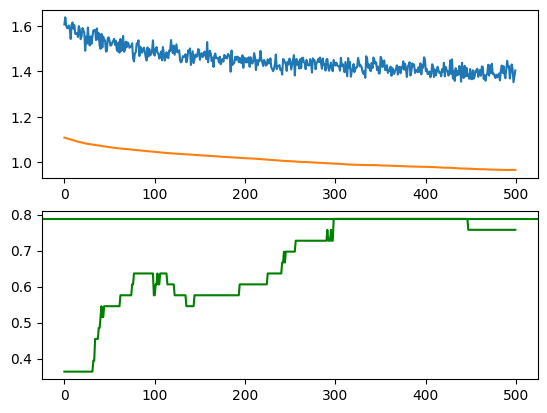

In [213]:
fig, (ax1, ax2) = plt.subplots(2, 1)
ax1.plot(losses)
ax1.plot(losses_t)
ax2.plot(accs, color="g")
ax2.axhline(best_model_valid, color="green")
print(np.min(losses_t))
torch.save({"model": ae.state_dict(), "optim": optim }, "model_004.pkl")

torch.Size([33, 206])


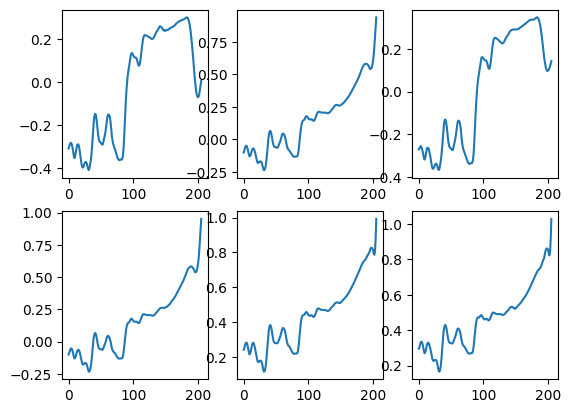

In [145]:
fig, axs = plt.subplots(2,3)
axs = axs.flatten()
print(x.shape)
for i, ax in enumerate(axs):
    ax.plot(Xs[i])
    #ax.plot(scaler.inverse_transform(xp[i].detach().numpy())[0])

In [71]:
ae.load_state_dict(best_model)
ae.eval()
latent, classification = ae.encode(torch.from_numpy(Xs).type(torch.float).reshape(-1, 1, len(wavelength)))
classification = np.argmax(classification.detach().numpy(), 1)
print(np.count_nonzero(classification==labels) / classification.shape[0])

latent, classification = ae.encode(torch.from_numpy(Xsv[:256]).type(torch.float).reshape(-1, 1, len(wavelength)))
classification = np.argmax(classification.detach().numpy(), 1)
print(np.count_nonzero(classification==labels_v[:256]) / classification.shape[0])
print(classification)
print(labels_v[:256])
print(len(classification))

0.5813953488372093
0.696969696969697
[1 0 1 0 2 2 0 1 0 0 0 1 1 0 0 0 1 1 1 0 1 1 1 0 1 1 1 1 1 1 1 1 0]
[2 0 2 0 2 2 2 2 0 0 2 2 0 0 0 0 0 0 1 1 1 1 1 0 1 1 1 1 1 1 1 1 0]
33


In [368]:
files_julie_r = glob("../raw_data/DataJulie/historique/*.asc")
import os
d_r = list()
for file in files_julie_r:
    d_r.append(read_asc(file)[1])

d_r=np.asarray(d_r)
d_r=d_r[:, wl_mask]
d_rmax = np.max(d_r, axis=1)
d_r /= d_rmax.reshape(d_r.shape[0], 1)
d_r = scaler.transform(d_r) / 5
_,classif = ae(torch.from_numpy(d_r).type(torch.float).reshape(-1, 1, len(wavelength)), classify=True)
pred_label = np.argmax(classif.detach(), axis=1)
for i, spec in enumerate(d_r):
    plt.plot(scaler.inverse_transform(spec.reshape(1, -1)), color=f"C{pred_label[i]}", alpha=1.0)
for file, clas, pond, spec in zip(files_julie_r, pred_label, classif, scaler.inverse_transform(d_r)):
    print(os.path.basename(file), clas.numpy(), pond.detach().numpy())
plt.legend()


NotFittedError: This StandardScaler instance is not fitted yet. Call 'fit' with appropriate arguments before using this estimator.

In [72]:
# let's shap !
import shap
import torch
import torch.nn as nn
ae.eval()
class Classifier(nn.Module):
    def __init__(self, ae):
        super(Classifier, self).__init__()
        self.ae = ae
        
    def forward(self, X):
        _, classif = self.ae(X)
        return classif

classif_model = Classifier(ae)
batch = torch.from_numpy(Xs).type(torch.float).reshape(-1, 1, len(wavelength))
idx = torch.randperm(batch.shape[0])
batch[idx, :] = batch.clone()
background = batch[:]
test_images = batch[:]
print(test_images.shape)

e = shap.DeepExplainer(classif_model, background)
shap_values = e.shap_values(test_images)
shap_values = np.asarray(shap_values).copy()
test_images=test_images[:, 0]
print(test_images.shape)


IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html


torch.Size([86, 1, 206])


Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.


torch.Size([86, 206])


In [ ]:
np.savez_compressed("perkin_shap_classic.npz", test_images=test_images, shap_values=shap_values)

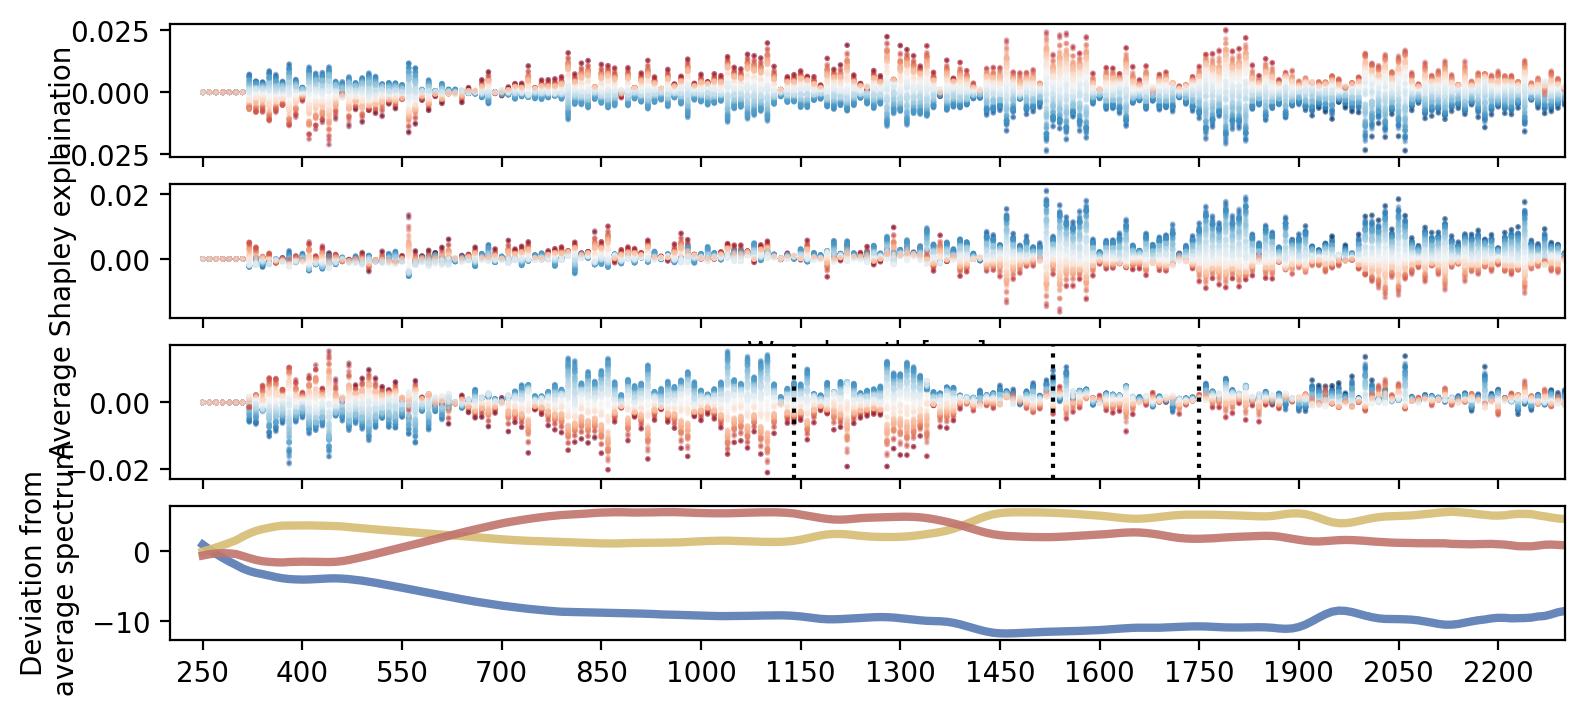

In [248]:
from matplotlib.cbook import get_sample_data
from matplotlib.offsetbox import (OffsetImage,AnnotationBbox)


fig, axs = plt.subplots(4,1, figsize=(9,4), sharex=True, sharey=False, dpi=200)
norm = plt.Normalize()
ti = norm(test_images[:,:].flatten().reshape(test_images.shape[0], -1))
for i in range(len(shap_values[0])):
    colors = plt.cm.RdBu(ti[i])
    axs[0].scatter(wavelength, (shap_values[0][i,:]), alpha=0.4, c=colors, s=1)
for i in range(len(shap_values[1])):
    colors = plt.cm.RdBu(ti[i])
    axs[1].scatter(wavelength, shap_values[1][i,:], alpha=0.4, c=colors, s=1)
for i in range(len(shap_values[2])):
    colors = plt.cm.RdBu(ti[i])
    axs[2].scatter(wavelength, shap_values[2][i,:], alpha=0.4, c=colors, s=1)
#axs[2].bar(x, np.mean((shap_values[2][:,:]), axis=0), alpha=0.9, width=15, c=colors)
axs[3].plot(wavelength, np.mean(X[Y[:,1]==0][:,:]-np.mean(X, axis=0), axis=0), alpha=0.9, c="#567ab4", lw=3)
axs[3].plot(wavelength, np.mean(X[Y[:,1]==1][:,:]-np.mean(X, axis=0), axis=0), alpha=0.9, c='#d6bd73', lw=3)
axs[3].plot(wavelength, np.mean(X[Y[:,1]==2][:,:]-np.mean(X, axis=0), axis=0), alpha=0.9, c="#c0736d", lw=3)
#axs[3].plot(x, np.mean(X, axis=0), "k:", alpha=0.9)
#axs[3].set_ylim(0, 1)
axs[2].axvline(1140, c='k', ls=":")
axs[2].axvline(1530, c='k', ls=":")
axs[2].axvline(1750, c='k', ls=":")

#for i in range(3):
#    axs[i].axvspan(400, 750, alpha=0.2, color="gray")
#axs[2].text(400, -5, "Visible range")
axs[1].set_ylabel("Average Shapley explaination")
axs[3].set_ylabel("Deviation from\n average spectrum")
axs[1].set_xlabel("Wavelength [nm]")

ab = AnnotationBbox(OffsetImage(plt.imread("../figs/cow.png", format='png'), zoom=0.15), [200, 0.0], xybox=(250, 0.5), xycoords='data', frameon=False,)
ab1 = AnnotationBbox(OffsetImage(plt.imread("../figs/sheep.png", format='png'), zoom=0.2), [200, 0.0], xybox=(250, 1.), xycoords='data', frameon=False,)
ab2 = AnnotationBbox(OffsetImage(plt.imread("../figs/goat.png", format='png'), zoom=0.2), [200, 0.0], xybox=(250, 1.), xycoords='data', frameon=False,)
for i in range(3):
    axs[i].set_xlim(200, 2300)
#axs[0].add_artist(ab)
#axs[1].add_artist(ab1)
#axs[2].add_artist(ab2)
axs[0].set_xticks(np.arange(np.min(wavelength), np.max(wavelength)+50, 150))

#plt.subplots_adjust(wspace=0, hspace=0)

In [247]:
# Use sweep data to produce the same graph
shap_sweep = list()
for i in range(50):
    file = f"../sweep/shaps_{i:03}.npz"
    data = np.load(file)
    shap_sweep.append(data["shap_values"])
shap_sweep = np.mean(shap_sweep, axis=0)
print(shap_sweep.shape)
shap_values= shap_sweep.copy()
test_images = data["test_images"]


(3, 119, 1, 206)


In [ ]:
from toolkit.dataset import load_spectral_data, dataset_dict_to_dense, normalize_spectra
dataset_dict = load_spectral_data([
    "../raw_data/DataJulie/11_09_2023_angel/*.asc",
], verbose=True)
Xtest, Ytest = dataset_dict_to_dense(dataset_dict)
Xtest = normalize_spectra(Xtest)
Xtest = Xtest[:, wl_mask]
Xtests = scaler.transform(Xtest)
ae.eval()
_, classif = ae(torch.from_numpy(Xtests).type(torch.float).reshape(-1, 1, len(wavelength)), classify=True)


In [ ]:
from toolkit.dataset import type
ae.eval()
grainflesh = ["C", "F"]
#label = ["Veau Chair", "Veau Fleur", "Mouton Chair", "Mouton Fleur", "Chevre Chair", "Chevre Fleur"]
label = ["Veau", "Mouton", "Chevre"]
Ytestp = np.argmax(classif.detach().numpy(), axis=-1)
for (name,_), pred in zip(dataset_dict.items(), Ytestp):
    #i###f "chevre" in name:
    print(name, label[pred])
print("Accuracy:", np.count_nonzero(Ytestp==Ytest[:, 1]) / len(Ytestp))


In [ ]:
plt.plot(X[np.logical_and(Y[:,1]==2, Y[:,4]==1)].T, alpha=0.1, color="k") # Chevre chair
plt.plot(X[np.logical_and(Y[:,1]==2, Y[:,4]==0)].T, alpha=0.1, color="r") # Chevre chair
plt.plot(Xtest[np.logical_and(Ytest[:,1]==2, Ytest[:,4]==1)].T)
#plt.plot(Xtest[np.logical_and(Ytest[:,1]==2, Ytest[:,4]==0)].T)

In [ ]:
fig, ax = plt.subplots(figsize=(2.2,2.2))
ax.plot(wavelength, X[9,:]+np.random.randn(len(X[0])), lw=3)
ax.set_xticks([300, 700, 1400, 2300])
plt.setp(ax.spines.values(), linewidth=3)
ax.tick_params(width=3)
fontdict={"fontsize": 12, "family":"times"}
ax.set_xlabel("Wavelength", fontdict=fontdict)
ax.set_ylabel("Spectrophotometer \nNorm. Flux", fontdict=fontdict)
fig.savefig("Spectre.svg", transparent=True)

In [ ]:
wavelength

In [16]:
good_model_data = torch.load("./very_good_model_on_histo.pkl")
ae.load_state_dict(good_model_data["model"])
ae.eval()
latent = ae(torch.from_numpy(Xs.reshape(Xs.shape[0], 1, -1)).type(torch.float), class) 

TypeError: scatter() missing 1 required positional argument: 'y'

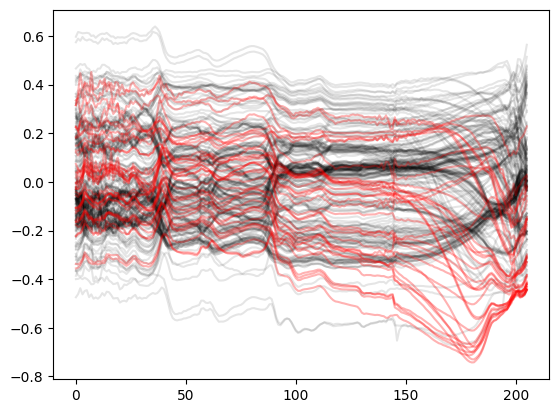

In [72]:
plt.plot(Xs.reshape(-1, 206).T, c="k", alpha=0.1)
plt.plot(Xsv.reshape(-1, 206).T, c="r", alpha=0.3)

In [1]:
accs = list()
for i in range(10):
    from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
    model = RandomForestClassifier()
    model.fit(Xs, Y[:, 1])
    preds = model.predict(Xsv) 
    accs.append(np.count_nonzero(preds == labels_v) / len(preds))
print(np.min(accs), np.max(accs), np.mean(accs))

NameError: name 'Xs' is not defined

KNN 0.45454545454545453 0.45454545454545453 0.45454545454545453
(206,)


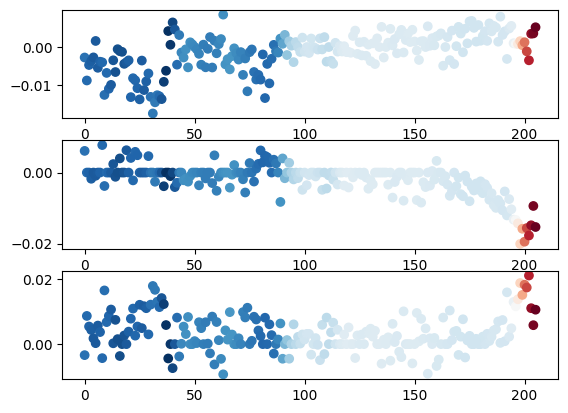

In [259]:
from sklearn.neighbors import KNeighborsClassifier
knn_accuracies = list()
for i in range(2, 3):#15
    model = KNeighborsClassifier(i)
    model.fit(Xs, Y[:, 1])
    preds = model.predict(Xsv) 
    acc = np.count_nonzero(preds == labels_v) / len(preds)
    knn_accuracies.append(acc)
print("KNN", np.min(knn_accuracies), np.max(knn_accuracies), np.mean(knn_accuracies))
import shap
explainer = shap.KernelExplainer(model.predict_proba, Xs)
shap_values = explainer.shap_values(Xsv[0])
print(shap_values[0].shape)
x = np.arange(len(shap_values[0]))
fig, (ax1, ax2, ax3) = plt.subplots(3)
ax1.scatter(x, shap_values[0], c=Xsv[0], cmap="RdBu")
ax2.scatter(x, shap_values[1], c=Xsv[0], cmap="RdBu")
ax3.scatter(x, shap_values[2], c=Xsv[0], cmap="RdBu")

In [243]:
from sklearn.decomposition import PCA
accs = list()
proj = PCA(150, svd_solver = 'auto')
proj.fit(Xtot)
for i in range(2, 15):
    model = KNeighborsClassifier(i)
    model.fit(proj.transform(Xs), labels) 
    preds = model.predict(proj.transform(Xsv)) 
    acc = np.count_nonzero(preds == labels_v) / len(preds)
    accs.append(acc)
print(np.min(accs), np.max(accs), np.mean(accs))


0.3333333333333333 0.6363636363636364 0.5477855477855479


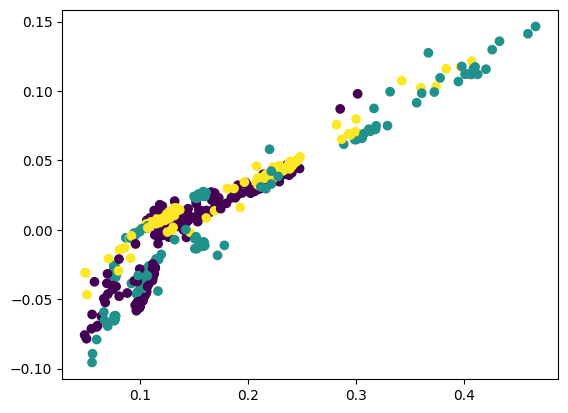

In [183]:
aelatent, _ = ae.encode(torch.from_numpy(Xtot).reshape(-1, 1, 206).type(torch.float))
aelatent = aelatent.detach().numpy()
plt.scatter(*aelatent.T, c=Ytot[:, 1])

In [193]:
from sklearn.neural_network import MLPClassifier
clf = MLPClassifier(max_iter=500,hidden_layer_sizes=(16, 8))
clf.fit(Xs, Y[:,1])
preds = clf.predict(Xsv) 
acc = np.count_nonzero(preds == labels_v) / len(preds)
print(acc)


0.48484848484848486


Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.


In [204]:
from sklearn.decomposition import PCA
proj = PCA(206, svd_solver = 'full')
proj.fit(Xtot)

model1 = KNeighborsClassifier(i)
model1.fit(proj.transform(Xs), labels) 
preds1 = model1.predict(proj.transform(Xsv)) 
model2 = KNeighborsClassifier(i)
model2.fit((Xs), labels) 
preds2 = model2.predict(Xsv) 
preds1 == preds2


array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True])

In [208]:
for i in range(10):
    x1 = np.sum((proj.transform(Xs)[i]-proj.transform(Xs)[i+1])**2)
    x2 = np.sum(((Xs)[i]-(Xs)[i+1])**2)
    print(x1, x2)

11.864674687377564 11.864674687377548
8.108528595295125 8.108528595295116
8.12488997951026 8.124889979510254
17.415837573708096 17.41583757370807
0.2654707482695473 0.2654707482695439
17.835031936958273 17.835031936958245
9.761788433741527 9.761788433741488
314.49057305554345 314.4905730555427
0.16439560562752528 0.16439560562752414
120.85081331933031 120.85081331933007


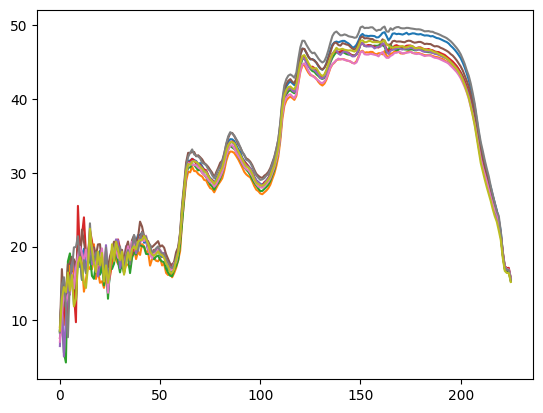

In [219]:
from glob import glob
files = glob("../raw_data/DataHenry/Perkin/3C-H10-C00*.Sample.Raw.asc")
for file in files:
    data = read_asc(file)[1]
    plt.plot(data)